In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from wilson_cowan_beta2 import *

import scipy.sparse as sp
import math

from kuramoto import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Synchrony

In [15]:
N = 50
wcn = nazemi_jamali_network(N, random_edges=0)
θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [16]:
ts, Es, Is = wcn.simulate(50, Δt = 1e-3)

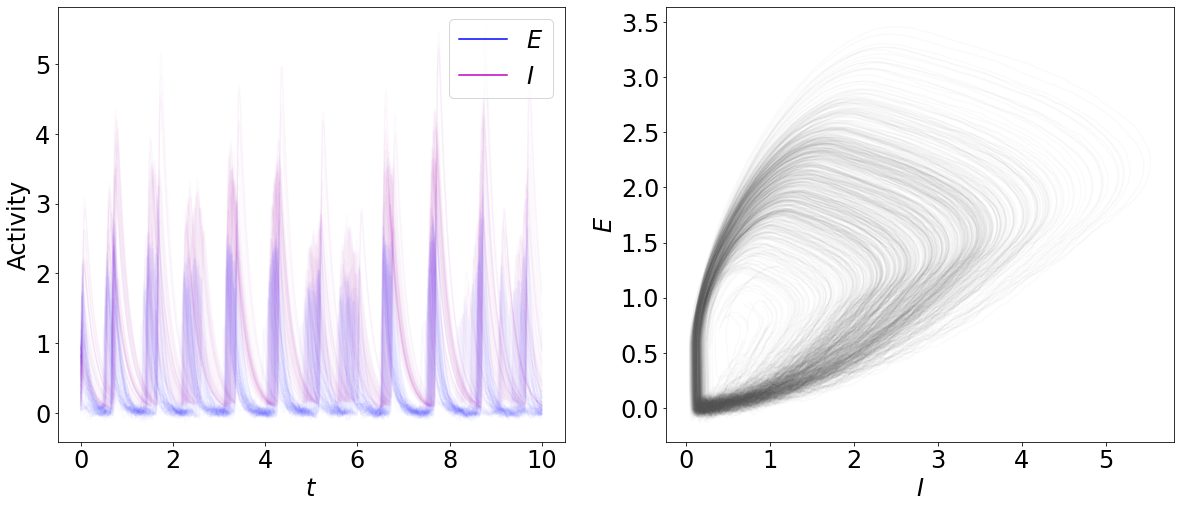

In [5]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

In [214]:
frame_start = 0#len(ts)//2
frame_stop = len(ts)#3*len(ts)//4
frame_stride = 30

angles = np.linspace(0, 2*np.pi, N, endpoint=False)
xs = np.cos(angles)
ys = np.sin(angles)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shrink_factor = 1.1
scatter_plot_excitatory = ax.scatter(xs, ys, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')
scatter_plot_inhibibory = ax.scatter(xs*shrink_factor, ys*shrink_factor, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')

def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

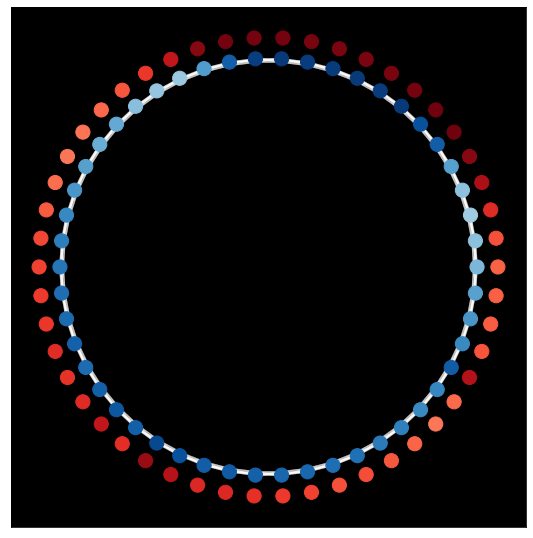

In [215]:
frame_start = len(ts)//2
frame_stop = 3*len(ts)//4
frame_stride = 30


angles = np.linspace(0, 2*np.pi, N, endpoint=False)
xs = np.cos(angles)
ys = np.sin(angles)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

time_index = 6950

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shrink_factor = 1.1
scatter_plot_excitatory = ax.scatter(xs, ys, s=size, c=Es[time_index], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')
scatter_plot_inhibibory = ax.scatter(xs*shrink_factor, ys*shrink_factor, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')


plt.tight_layout()

# plt.savefig('images/proposal_ring_pulse.png')

plt.show()

# Perc

In [9]:
def node_to_grid(a, n):
    return a%n, a//n

def grid_to_node(x, y, n):
    return x + y*n

In [16]:
n = 10
N = n**2

In [17]:
coupling_weight=.8

coupling_edges = []
for node in range(N):
    x, y = node_to_grid(node, n)
    if x < n-1:
        coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
    if y < n-1:
        coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))
    
    
coupling_edges = randomize_edges(N, coupling_edges, 5)

In [18]:
def perc_network(n, coupling_weight=.8, neighbor_radius=3, random_edges = 0):
    '''
    Networks from Perc (2005) - Chaos Solitons and Fractals.
    '''
    N = n**2
    
    EE_weight = 8
    II_weight = 4
    EI_weight = 16
    IE_weight = 8

    # standard Wilson-Cowan connections
    EE_edges = [(a, a, EE_weight) for a in range(N)]
    II_edges = [(a, a, II_weight) for a in range(N)]
    EI_edges = [(a, a, EI_weight) for a in range(N)]
    IE_edges = [(a, a, IE_weight) for a in range(N)]

    # grid connections
    coupling_edges = []
    for node in range(N):
        x, y = node_to_grid(node, n)
        if x < n-1:
            coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
        if y < n-1:
            coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))

    coupling_edges = randomize_edges(N, coupling_edges, random_edges)

    EE_edges = EE_edges + coupling_edges
    
    matrix_type = 'dense'
    if N > 100:
        matrix_type = 'csr'

    EE_mat = edges_to_adjacency_matrix(N, EE_edges, symmetric=True, matrix_type=matrix_type)
    II_mat = edges_to_adjacency_matrix(N, II_edges, symmetric=True, matrix_type=matrix_type)
    EI_mat = edges_to_adjacency_matrix(N, EI_edges, symmetric=True, matrix_type=matrix_type)
    IE_mat = edges_to_adjacency_matrix(N, IE_edges, symmetric=True, matrix_type=matrix_type)

    wcn = Wilson_Cowan_Network(EE_mat, EI_mat, IE_mat, II_mat)

    aE = 0.8
    θE = 2
    wcn.excitatory_firing_rate = lambda x: sigmoid(aE*(x - θE))
    aI = 0.8
    θI = 8
    wcn.inhibitory_firing_rate = lambda x: sigmoid(aI*(x - θI))

    wcn.E0 = np.random.random(N)
    wcn.I0 = np.random.random(N)
    
    return wcn

In [19]:
wcn = perc_network(n, coupling_weight=.8, neighbor_radius=3, random_edges = 0)
θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [20]:
ts, Es, Is = wcn.simulate(10, Δt = 1e-3)

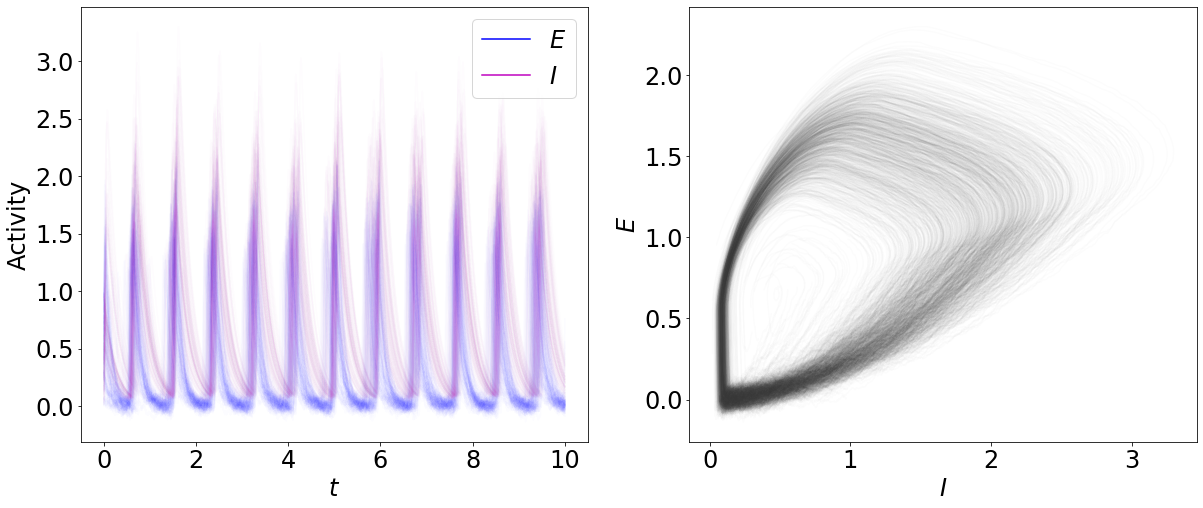

In [21]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

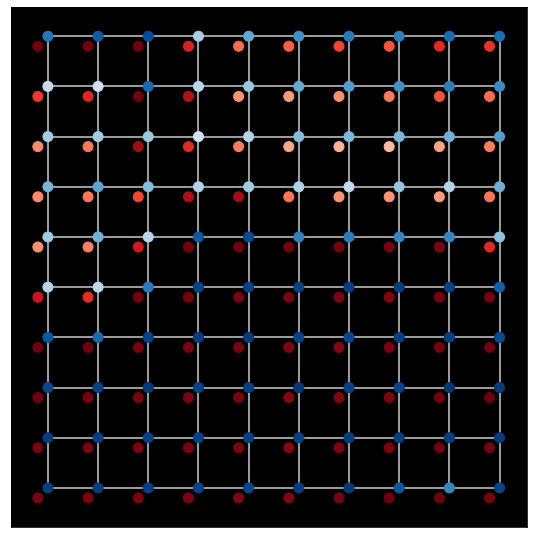

In [23]:
X, Y = np.meshgrid(range(n), range(n))

X = X.flatten()
Y = Y.flatten()

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

time_index = 6700

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 100
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[time_index], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


plt.tight_layout()

# plt.savefig('images/proposal_grid_pulse.png')

plt.show()

In [27]:
X, Y = np.meshgrid(range(n), range(n))

X = X.flatten()
Y = Y.flatten()

frame_start = 0#len(ts)//2
frame_stop = len(ts)#3*len(ts)//4
frame_stride = 20

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

# Hexagons are the Bestagons

In [28]:
def dist_squared(point1, point2):
    return sum((x-y)**2 for x, y in zip(point1, point2))

In [29]:
dist_squared((0,0), (2, 2))

8

In [30]:
hex_radius = 3
coupling_weight = 0.8

N = 1 + 3*hex_radius + 3*hex_radius**2

x_locations = [0]
y_locations = [0]
w = np.exp(np.pi/3*1j)

for r in range(1, hex_radius+1):
    new_points = np.arange(r)*w**2 + r
    for power in range(6):
        x_locations += list(np.real(new_points*w**power))
        y_locations += list(np.imag(new_points*w**power))
    


coupling_edges = [(a, b, coupling_weight) 
         for a, point1 in enumerate(zip(x_locations, y_locations))
         for b, point2 in enumerate(zip(x_locations, y_locations))
         if a!=b and dist_squared(point1, point2)<1.1]

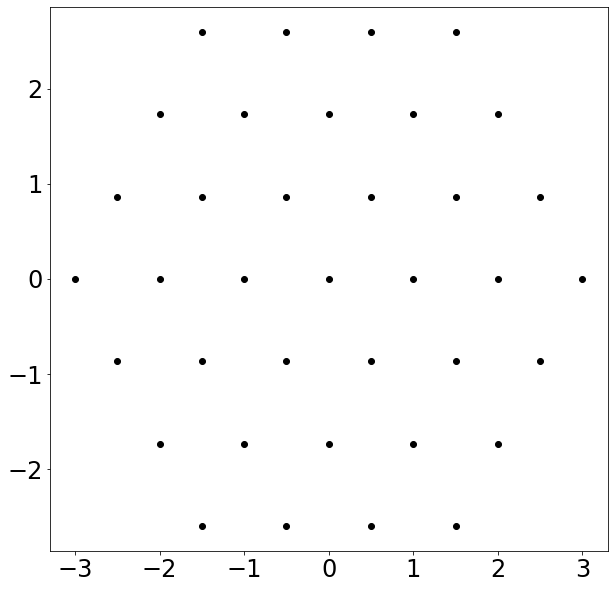

In [31]:
plt.figure(figsize=(10,10))
plt.plot(x_locations, y_locations, 'ko')

In [32]:

EE_weight = 8
II_weight = 4
EI_weight = 16
IE_weight = 8

# standard Wilson-Cowan connections
EE_edges = [(a, a, EE_weight) for a in range(N)]
II_edges = [(a, a, II_weight) for a in range(N)]
EI_edges = [(a, a, EI_weight) for a in range(N)]
IE_edges = [(a, a, IE_weight) for a in range(N)]

# ring connections
# coupling_edges = []
# for node in range(N):
#     x, y = node_to_grid(node, n)
#     if x < n-1:
#         coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
#     if y < n-1:
#         coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))

# coupling_edges = randomize_edges(N, coupling_edges, random_edges)

EE_edges = EE_edges + coupling_edges

matrix_type = 'dense'
if N > 100:
    matrix_type = 'csr'

EE_mat = edges_to_adjacency_matrix(N, EE_edges, symmetric=True, matrix_type=matrix_type)
II_mat = edges_to_adjacency_matrix(N, II_edges, symmetric=True, matrix_type=matrix_type)
EI_mat = edges_to_adjacency_matrix(N, EI_edges, symmetric=True, matrix_type=matrix_type)
IE_mat = edges_to_adjacency_matrix(N, IE_edges, symmetric=True, matrix_type=matrix_type)

wcn = Wilson_Cowan_Network(EE_mat, EI_mat, IE_mat, II_mat)

aE = 0.8
θE = 2
wcn.excitatory_firing_rate = lambda x: sigmoid(aE*(x - θE))
aI = 0.8
θI = 8
wcn.inhibitory_firing_rate = lambda x: sigmoid(aI*(x - θI))

wcn.E0 = np.random.random(N)
wcn.I0 = np.random.random(N)

θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [33]:
Δt = 1e-3
ts, Es, Is = wcn.simulate(10, Δt=Δt)

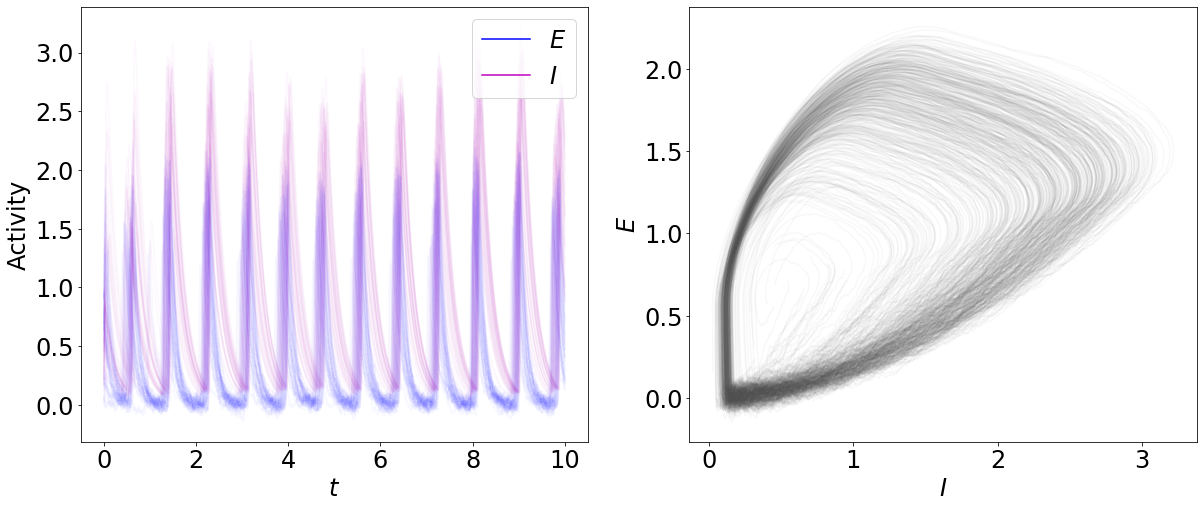

In [34]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

In [35]:
X = np.array(x_locations) #+ np.random.randn(N)*.05
Y = np.array(y_locations) #+ np.random.randn(N)*.05

frame_start = 0#len(ts)//2
frame_stop = len(ts)#//10#3*len(ts)//4
frame_stride = 10

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

# Phase Measure

In [17]:
series = Es[:,1]

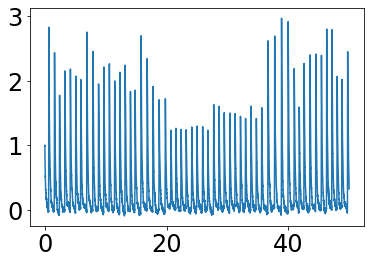

In [18]:
plt.plot(ts, series)

In [32]:
'''
Some functions implementing the Kuramoto measure on time series data.
'''

def refine_max(guess_index, series, window=10, max_iter=100):
    '''
    Refines an approximate times series spike index to be more accurate.
    '''
    old_index = guess_index
    try:
        for _ in range(max_iter):
            index = np.argmax(series[old_index-window:old_index+window]) + (old_index-window)
            if index == old_index:
                break
            old_index = index
        return index
    except:
        return None

# Some threshold functions

def series_midpoint(series):
    my_max, my_min = np.max(series), np.min(series)
    return (my_max - my_min)/2 + my_min

def quantile_90(series):
    return np.quantile(series, 0.9)

threshold_function = quantile_90

def get_spike_indices_approx(ts, series, threshold_function=threshold_function):
    '''
    Find approximate spike indices for the given time series. Applies a Heaviside filter
    with a threshold decided by the provided threshold_function. Then Does a 2 point finite
    difference to identify approximate rising times.
    '''
    threshold = threshold_function(series)
    spiking = np.heaviside(series-threshold, 0)
    kernel = np.array([1, -1]) #detect rises
    rising_signal = np.convolve(spiking, kernel, mode='same')
    spike_mask = rising_signal == 1
    return np.arange(len(series))[spike_mask]

def get_spike_indices(ts, series, threshold_function=threshold_function, window=10):
    spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=threshold_function)
    spike_indices = [refine_max(guess, series) for guess in spike_indices_approx]
    spike_indices = [index for index in spike_indices if index is not None]
    spike_indices = list(set(spike_indices)) # remove duplicates
    spike_indices.sort()
    return spike_indices

def get_kuramoto_phase(t, ts, spike_indices):
    next_spike_num = np.argmax(np.heaviside(ts[spike_indices] - t, 0))
    next_spike_num = np.argmax(np.heaviside(ts[spike_indices] - t, 0))
    if next_spike_num == 0:
        return np.nan #returns nan if before first spike or after last spike
    tf = ts[spike_indices[next_spike_num]]
    t0 = ts[spike_indices[next_spike_num-1]]
    phase = (t-t0)/(tf-t0) * 2*np.pi
    return phase

def series_to_phase(ts, series, threshold_function=threshold_function):
    spike_indices = get_spike_indices(ts, series, threshold_function=threshold_function)
    phases = [get_kuramoto_phase(t, ts, spike_indices) for t in ts]
    return phases

def kuramoto_measure(ts, time_series, threshold_function=threshold_function):
    phases = np.empty(time_series.shape)
    for series_index, series in enumerate(time_series):
        phases[series_index] = series_to_phase(ts, series, threshold_function=threshold_function)
    
    kuramoto = np.abs(np.sum(np.exp(1j*phases), axis=0)/phases.shape[0])
    return kuramoto

def _nan_filter(series):
    return series[np.logical_not(np.isnan(series))]

def average_kuramoto(kuramoto):
    return np.mean(_nan_filter(kuramoto))

In [33]:
threshold_function = lambda series: np.quantile(series, 0.9)
spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=threshold_function)

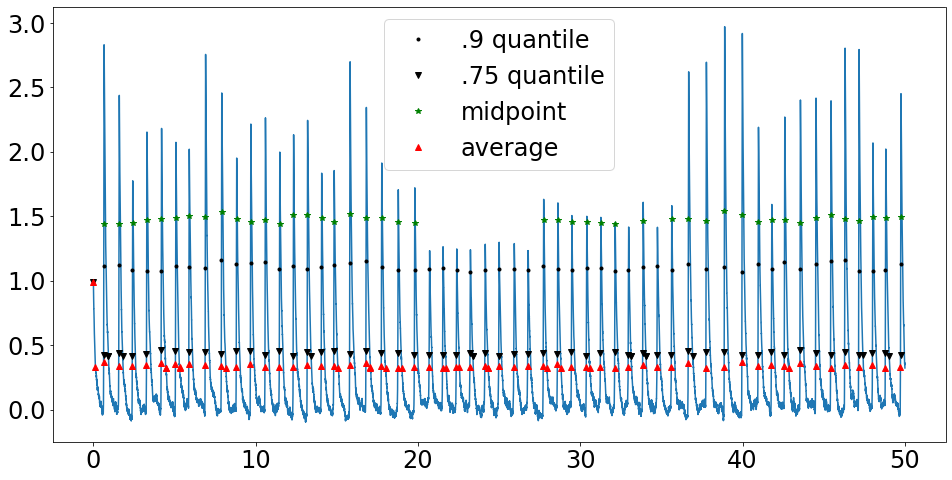

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(ts, series)
spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=lambda series: np.quantile(series, .9))
plt.plot(ts[spike_indices_approx], series[spike_indices_approx], 'k.', label='.9 quantile')
spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=lambda series: np.quantile(series, .75))
plt.plot(ts[spike_indices_approx], series[spike_indices_approx], 'kv', label='.75 quantile')

spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=series_midpoint)
plt.plot(ts[spike_indices_approx], series[spike_indices_approx], 'g*', label='midpoint')

spike_indices_approx = get_spike_indices_approx(ts, series, threshold_function=np.average)
plt.plot(ts[spike_indices_approx], series[spike_indices_approx], 'r^', label='average')

plt.legend()
# plt.savefig('kuramoto_threshold_functions.png')

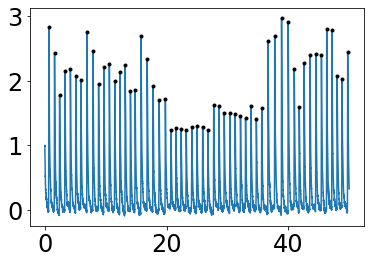

In [22]:
spike_indices = get_spike_indices(ts, series, threshold_function=threshold_function)
plt.plot(ts, series)
plt.plot(ts[spike_indices], series[spike_indices], 'k.')

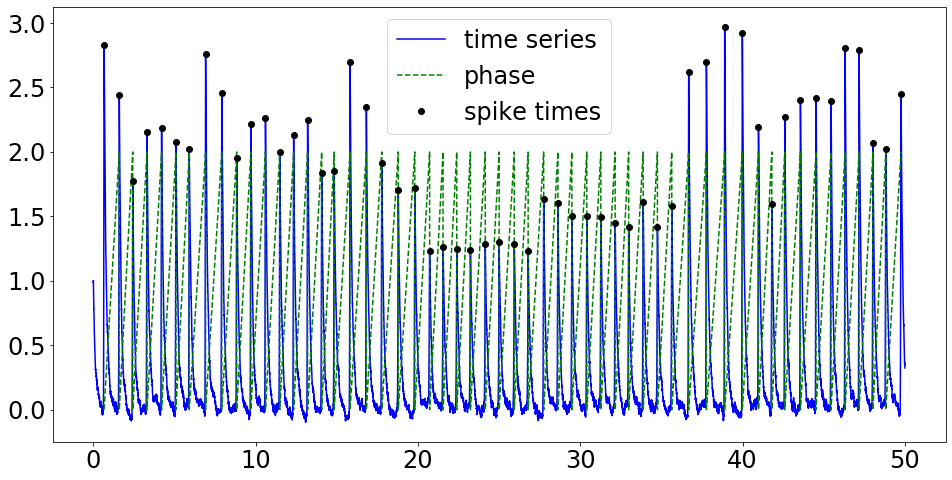

In [23]:
spike_indices = get_spike_indices(ts, series, threshold_function)
phases = series_to_phase(ts, series)
plt.figure(figsize=(16, 8))
plt.plot(ts, series, 'b-', label='time series')
plt.plot(ts, np.array(phases) / np.pi, 'g--', label='phase')
plt.plot(ts[spike_indices], series[spike_indices], 'ko', label='spike times')
plt.legend()
plt.show()

In [24]:
kuramoto = kuramoto_measure(ts, Es.T, threshold_function=threshold_function)

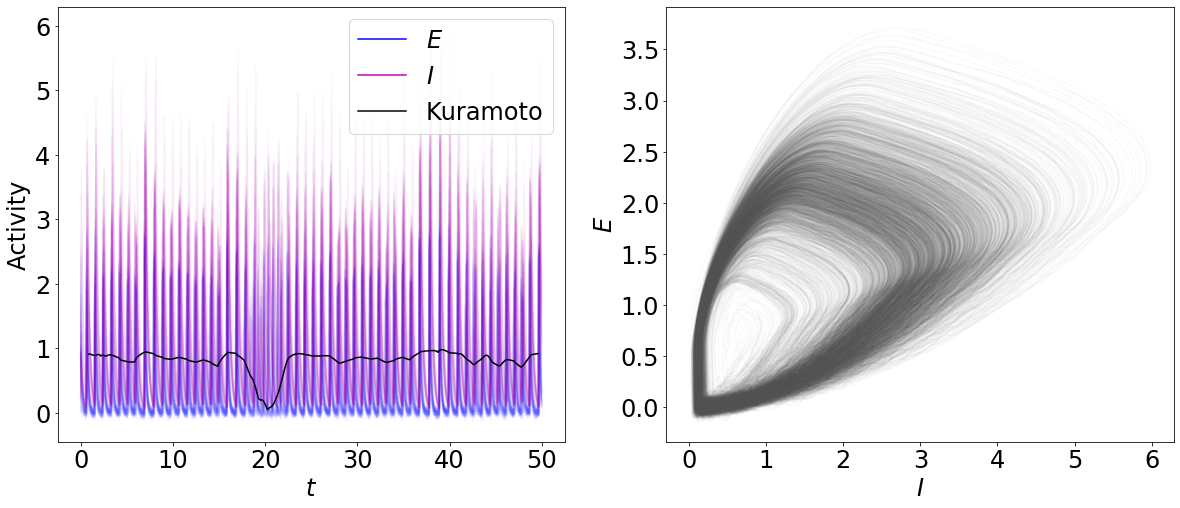

In [25]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.plot(ts, kuramoto, 'k-', label='Kuramoto')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')
# plt.savefig('kuramoto_test1.png')
plt.show()

average = 0.8084554129211283


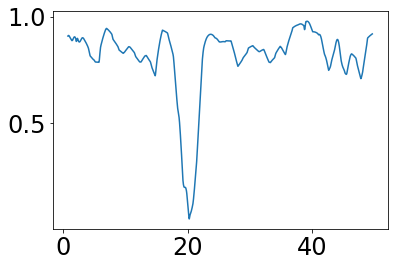

In [34]:
plt.plot(ts, kuramoto)
print(f'average = {average_kuramoto(kuramoto)}')

In [35]:
np.median(nan_filter(kuramoto))

0.8445953887584313